# Maching Learning - Neural Network

CS640

In [6]:
import numpy as np
import time
import math
import matplotlib.pyplot as plt

## NN Model 

In [123]:
# Activation functions and derivative
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    return np.multiply(x, (1.0 - x))

def tanh(x):
    return np.tanh(x)

def tanh_prime(x):
    return 1.0 - x ** 2

def softmax(x):
    return (np.exp(np.array(x)) / np.sum(np.exp(np.array(x))))

def softmax_prime(y,t):
    return y - t

def cross_entropy(pred, y):
    """
    X is the output from fully connected layer (num_examples x num_classes)
    y is labels (num_examples x 1)
    Note that y is not one-hot encoded vector.
    It can be computed as y.argmax(axis=1) from one-hot encoded vectors of labels if required.
    """
    m = y.shape[0]
    p = pred
    #print('pred ', pred.shape)
    y=y.reshape(m,)
    #print('y', y.shape)
    # We use multidimensional array indexing to extract
    # softmax probability of the correct label for each sample.
    log_likelihood = -np.log(p[range(m), y.astype(int)])
    loss = np.sum(log_likelihood) / m
    return loss

def ReLU(x):
    return np.maximum(x, 0.0)

def ReLU_prime(x):
    return 1.0 * ( x > 0 )


class NeuralNetwork(object):
    """
    This PA implements a Neural Network with 3 layers.
    """
    
    def __init__(self, input_num, hidden_num, output_num, 
                         hidden_activation='tanh', output_activation='softmax', 
                         regular_factor=None, drop_out=False):
        """
        Initializes the parameters of the NN with random weights.
        
        args:
            input_num: Number of nodes of the input layer
            hidden_num: Number of nodes of the hidden layer
            output_num: Number of nodes of the output layer
            hidden_activation: Activation function use for hidden layer
            output_activation: Activation function use for output layer
            regular_factor: Factor used for L2 regularization
            drop_out: Whether to use drop out
        """
        
        self.input_num = input_num
        self.hidden_num = hidden_num
        self.output_num = output_num
        self.regular_factor = regular_factor
        self.drop_out = drop_out
        
        # Weights initializarion
        self.wih = np.random.randn(input_num + 1, hidden_num)
        self.who = np.random.randn(hidden_num + 1, output_num)
        self.softmax = False
        
        # Hidden layer activation function
        if hidden_activation == 'sigmoid':
            self.hidden_activation = sigmoid
            self.hidden_activation_prime = sigmoid_prime
        elif hidden_activation == 'tanh':
            self.hidden_activation = tanh
            self.hidden_activation_prime = tanh_prime
        elif hidden_activation == 'ReLU':
            self.hidden_activation = ReLU
            self.hidden_activation_prime = ReLU_prime

        # Output layer activation function
        if output_activation == 'sigmoid':
            self.output_activation = sigmoid
            self.output_activation_prime = sigmoid_prime
        elif output_activation == 'tanh':
            self.output_activation = tanh
            self.output_activation_prime = tanh_prime
        elif output_activation == 'ReLU':
            self.output_activation = ReLU
            self.output_activation_prime = ReLU_prime
        elif output_activation == 'softmax':
            self.output_activation = softmax
            self.output_activation_prime = softmax_prime
            self.softmax = True

    def predict(self, X):
        """
        Calculate the NN's output for given input samples
        
        args:
            X: Data array

        returns:
            y: NN's Output corresponding to input data
        """
        
        input_num = X.shape[0]
        y = np.zeros([input_num, self.output_num])
        for i in range(0, input_num):
            y[i] = self.forward(X[i])
        
        return y

    def predict_classify(self, X):
        """
        Classify the label for given input samples
        
        args:
            X: Data array

        returns:
            Labels corresponding to input data
        """
        
        return self.decode_output(self.predict(X))
    
    def forward(self, X):
        """
        Calculate the output by NN for a given input sample
        
        args:
            X: A sample array (row vector)

        returns:
            y: NN's Output corresponding to input data
        """
        
        # Adding bias to input, 1 x n vector
        hidden_layer_in = np.hstack([np.mat(X), np.mat(np.ones(1))])

        # Hidden layer activation
        hidden_layer_out = self.hidden_activation(np.dot(hidden_layer_in, self.wih))

        # Adding bias to the hidden layer results
        output_layer_in = np.hstack([hidden_layer_out, np.mat(np.ones(1))])

        # Outputs
        y = self.output_activation(np.dot(output_layer_in, self.who))

        return y

    def fit(self, X, y, epochs=10, batch_size=16, learning_rate=0.2, learning_rate_decay=0, verbose=False):
        """
        Use BP algorithm to train the NN
        
        args:
            X: Data array
            y: Label correspond to each sample
            epochs: Number of epoch to train
            batch_size: Size of a training batch
            learning_rate: How fast one move step
            learning_rate_decay: Factor for decreasing the learning rate after each epoch
            verbose: Whether to output debug info

        returns:
            epoch_loss: The loss for each epoch
        """
        
        startTime = time.time()
        
        epoch_loss = []

        for epoch in range(epochs):
            
            # split into batches
            batches = self.shuffle(X, y, batch_size)
            
            for batch_id in range(len(batches)):
                
                # Get the Xs and ys in batch
                batch_X, batch_y = batches[batch_id]
                
                sample_amount = batch_X.shape[0]
                
                wih_gradients = np.zeros([sample_amount, *self.wih.shape])
                who_gradients = np.zeros([sample_amount, *self.who.shape])
                
                for sample_id in range(sample_amount):

                    # Adding bias to input, 1 x n vector
                    hidden_layer_in = np.hstack([np.mat(batch_X[sample_id]), np.mat(np.ones(1))])
                    # Hidden layer activation
                    hidden_layer_out = self.hidden_activation(np.dot(hidden_layer_in, self.wih))
                    
                    if self.drop_out:
                        hidden_layer_out, mask = self.dropout_forward(hidden_layer_out)
                    
                    # Adding bias to the hidden layer results
                    output_layer_in = np.hstack([hidden_layer_out, np.mat(np.ones(1))])
                    
                    # Outputs
                    output_layer_out = self.output_activation(np.dot(output_layer_in, self.who))

                    if self.output_num > 1:
                        one_hot_y = np.zeros_like(output_layer_out)
                        one_hot_y[0, batch_y[sample_id][0].astype(int)] = 1.0
                    else:
                        one_hot_y = batch_y[sample_id]

                    # Deltas
                    if self.softmax:
                        delta_output = one_hot_y - output_layer_out
                    else:
                        delta_output = np.multiply(self.output_activation_prime(output_layer_out),
                                               one_hot_y - output_layer_out)
                    delta_hidden = np.multiply(self.hidden_activation_prime(output_layer_in), np.dot(delta_output, self.who.T))

                    # Weights update
                    update_output = np.multiply(learning_rate, np.outer(output_layer_in, delta_output))
                    update_hidden = np.multiply(learning_rate, np.outer(hidden_layer_in, delta_hidden[:, :-1]))

                    # L2 regularization
                    if self.regular_factor:
                        update_output -= self.regular_factor * self.who
                        update_hidden -= self.regular_factor * self.wih
                    
                    # Save the gradient for current sample
                    wih_gradients[sample_id] = update_hidden
                    who_gradients[sample_id] = update_output
                
                # Average gradient in a batch
                wih_gradients_mean = np.mean(wih_gradients, axis=0)
                who_gradients_mean = np.mean(who_gradients, axis=0)
                
                if self.drop_out:
                    wih_gradients_mean = self.dropout_backward(wih_gradients_mean, mask)
                
                # Weights update
                self.wih += wih_gradients_mean
                self.who += who_gradients_mean
                
            # Print training status
            if verbose:
                err, acc = self.calculateError(X, y)
                print('Epoch:{}/{}\tLoss:{:2f}\tAccuracy:{:6f}\tLearning rate:{}\tElapse time[s]:{:2f}'\
                      .format(epoch+1, epochs,  err,        acc,            learning_rate,    time.time() - startTime))
                epoch_loss.append(err)
                
            # Learning rate update
            learning_rate = learning_rate * (1 - learning_rate_decay)
        
        if verbose:
            return epoch_loss

    def shuffle(self, X, y, batch_size):
        """
        Randomly shuffle the data
        
        args:
            X: Data array
            y: Label correspond to each sample
            batch_size: Size of a batch
    
        returns:
            Each group with X and y
        """
        
        data_size = X.shape[0]
        idx = np.array(range(data_size))
        np.random.shuffle(idx)  
        
        batch_num = math.ceil(data_size / batch_size)
        idx_groups = [ idx[i*batch_size : (i+1)*batch_size] for i in range(0, batch_num) ]
        
        return [(X[idxs], y[idxs]) for idxs in idx_groups]
    
    def decode_output(self, outs):
        """
        Convert the NN's output to actual label
        
        args:
            outs: Data array from NN's output
    
        returns:
            The labels correspond to each sample
        """
        
        input_num = outs.shape[0]
        if outs.shape[1] > 1:
            labels = np.argmax(outs,axis=1).astype(int)
        else:
            labels = outs
            labels[labels>=0.5] = 1
            labels[labels<0.5] = 0
            
        return labels

    def calculateError(self, X, y):
        """
        Convert the loss and accuracy for given X and y
        
        args:
            X: Data array
            y: Labels for each input sample
    
        returns:
            err: The loss for current dataset
            accur: The accuracy for current dataset
        """
        
        output = self.predict(X)
        
        if self.output_num > 1:
            one_hot_y = np.zeros_like(output)
            for i in range(X.shape[0]):
                one_hot_y[i,int(y[i])] = 1

            delta = one_hot_y - output
        else:
            delta = y - output
        
        # softmax
        if self.softmax:
            err = cross_entropy(output, y)
        else:
            err = np.sum(np.power(delta, 2)) / 2

        # L2 regular
        if self.regular_factor:
            err += self.regular_factor / 2 * (np.sum(np.power(self.who, 2)) + np.sum(np.power(self.wih, 2)))

        
        labels = self.decode_output(output)
                        
        accur = sum([1 for i in range(y.shape[0]) if y[i] == labels[i]]) / (y.shape[0])
        
        return err, accur


    def dropout_forward(self, x, level=0.2):
        """
        Calculate the dropout mask matrix and do the dropout
        
        args:
            X: Data array
            level: drop out level
    
        returns:
            x: The data after drop out
            random_tensor: drop out mask matrix
        """
        
        if level < 0 or level >= 1:  # level is probability，must within [0,1].
            raise ValueError('Dropout level must be in interval [0, 1].')
        
        retain_prob = 1. - level
        random_tensor = np.random.binomial(n=1, p=retain_prob, size=x.shape)  # generate a binomimal vector

        x = np.multiply(x, random_tensor)
        x /= retain_prob
        return x, random_tensor

    def dropout_backward(self, x, mask):
        """
        Using the given mask to calculate the matrix for BP
        
        args:
            X: Data array
            mask: drop out mask matrix
    
        returns:
            x: The matrix after drop out
        """
        
        return x * mask    
    


In [68]:
def plot_decision_boundary(model, X, y):
    """
    Function to print the decision boundary given by model.
    
    args:
        model: model, whose parameters are used to plot the decision boundary.
        X: input data
        y: input labels
    """
    
    x1_array, x2_array = np.meshgrid(np.arange(-0.1, 1.1, 0.01), np.arange(-0.1, 1.1, 0.01))
    grid_coordinates = np.c_[x1_array.ravel(), x2_array.ravel()]
    Z = model.predict_classify(grid_coordinates)
    Z = Z.reshape(x1_array.shape)
    plt.contourf(x1_array, x2_array, Z, cmap=plt.cm.bwr)
    plt.scatter(X[:, 0], X[:, 1], c=[v[0] for v in y], cmap=plt.cm.bwr)
    plt.show()

## Linear Data (Five fold round robin cross-validation)

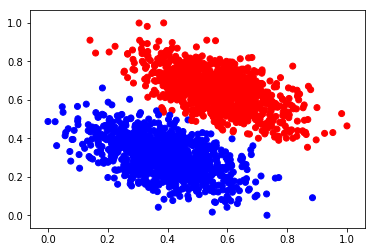

In [63]:
#1. load data
X = np.genfromtxt('DATA/data_linearX.csv', delimiter=',').astype(np.float64)
y = np.genfromtxt('DATA/data_linearY.csv', delimiter=',').astype(np.float64)
y = y.reshape(y.shape[0], 1)

# Normalize X
X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

#2. plot data
plt.scatter(X[:,0], X[:,1], c=[v[0] for v in y], cmap=plt.cm.bwr)
plt.show()

Round: 1
Epoch:1/20	Loss:190.959983	Accuracy:0.965000	Learning rate:0.5	Elapse time[s]:0.466503
Epoch:2/20	Loss:186.449207	Accuracy:0.581250	Learning rate:0.5	Elapse time[s]:0.931990
Epoch:3/20	Loss:181.179283	Accuracy:0.992500	Learning rate:0.5	Elapse time[s]:1.393908
Epoch:4/20	Loss:176.223870	Accuracy:0.966250	Learning rate:0.5	Elapse time[s]:1.844433
Epoch:5/20	Loss:170.539862	Accuracy:0.986875	Learning rate:0.5	Elapse time[s]:2.324232
Epoch:6/20	Loss:163.793044	Accuracy:0.986875	Learning rate:0.5	Elapse time[s]:2.828765
Epoch:7/20	Loss:156.517764	Accuracy:0.972500	Learning rate:0.5	Elapse time[s]:3.345430
Epoch:8/20	Loss:148.942183	Accuracy:0.935000	Learning rate:0.5	Elapse time[s]:3.823146
Epoch:9/20	Loss:139.823693	Accuracy:0.983125	Learning rate:0.5	Elapse time[s]:4.283976
Epoch:10/20	Loss:130.167296	Accuracy:0.988125	Learning rate:0.5	Elapse time[s]:4.728844
Epoch:11/20	Loss:123.194424	Accuracy:0.955625	Learning rate:0.5	Elapse time[s]:5.178893
Epoch:12/20	Loss:113.951365	Accu

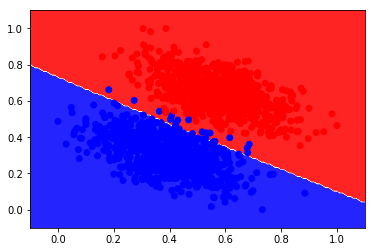


ACCURACY:  0.9925
CONFUSION MATRIX: 
 [[199.   0.]
 [  3. 198.]]


Round: 2
Epoch:1/20	Loss:209.291266	Accuracy:0.516250	Learning rate:0.5	Elapse time[s]:0.515669
Epoch:2/20	Loss:197.736150	Accuracy:0.646875	Learning rate:0.5	Elapse time[s]:0.957743
Epoch:3/20	Loss:187.280867	Accuracy:0.864375	Learning rate:0.5	Elapse time[s]:1.392346
Epoch:4/20	Loss:180.082333	Accuracy:0.544375	Learning rate:0.5	Elapse time[s]:1.841539
Epoch:5/20	Loss:170.717141	Accuracy:0.965000	Learning rate:0.5	Elapse time[s]:2.287834
Epoch:6/20	Loss:162.867161	Accuracy:0.837500	Learning rate:0.5	Elapse time[s]:2.726890
Epoch:7/20	Loss:152.946838	Accuracy:0.978750	Learning rate:0.5	Elapse time[s]:3.300095
Epoch:8/20	Loss:142.440507	Accuracy:0.976250	Learning rate:0.5	Elapse time[s]:3.796463
Epoch:9/20	Loss:133.442189	Accuracy:0.966250	Learning rate:0.5	Elapse time[s]:4.274405
Epoch:10/20	Loss:123.591154	Accuracy:0.994375	Learning rate:0.5	Elapse time[s]:4.762436
Epoch:11/20	Loss:113.510468	Accuracy:0.996875	Learni

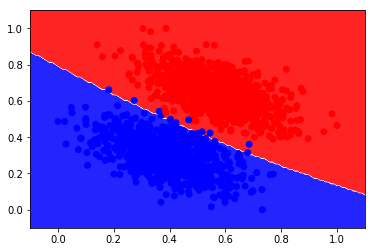


ACCURACY:  0.9875
CONFUSION MATRIX: 
 [[221.   0.]
 [  5. 174.]]


Round: 3
Epoch:1/20	Loss:184.209153	Accuracy:0.905625	Learning rate:0.5	Elapse time[s]:0.530748
Epoch:2/20	Loss:175.535676	Accuracy:0.974375	Learning rate:0.5	Elapse time[s]:0.991757
Epoch:3/20	Loss:164.807025	Accuracy:0.973125	Learning rate:0.5	Elapse time[s]:1.463046
Epoch:4/20	Loss:156.158420	Accuracy:0.994375	Learning rate:0.5	Elapse time[s]:1.929049
Epoch:5/20	Loss:145.934394	Accuracy:0.993750	Learning rate:0.5	Elapse time[s]:2.355330
Epoch:6/20	Loss:137.834005	Accuracy:0.990625	Learning rate:0.5	Elapse time[s]:2.798393
Epoch:7/20	Loss:128.622056	Accuracy:0.983125	Learning rate:0.5	Elapse time[s]:3.259475
Epoch:8/20	Loss:120.141461	Accuracy:0.985625	Learning rate:0.5	Elapse time[s]:3.696036
Epoch:9/20	Loss:110.183669	Accuracy:0.988750	Learning rate:0.5	Elapse time[s]:4.132400
Epoch:10/20	Loss:103.698327	Accuracy:0.979375	Learning rate:0.5	Elapse time[s]:4.565062
Epoch:11/20	Loss:94.823178	Accuracy:0.994375	Learnin

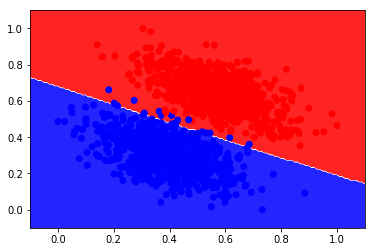


ACCURACY:  0.9975
CONFUSION MATRIX: 
 [[192.   0.]
 [  1. 207.]]


Round: 4
Epoch:1/20	Loss:192.844012	Accuracy:0.513750	Learning rate:0.5	Elapse time[s]:0.502712
Epoch:2/20	Loss:183.482277	Accuracy:0.760000	Learning rate:0.5	Elapse time[s]:0.962863
Epoch:3/20	Loss:178.192891	Accuracy:0.595625	Learning rate:0.5	Elapse time[s]:1.417746
Epoch:4/20	Loss:172.420110	Accuracy:0.928125	Learning rate:0.5	Elapse time[s]:1.865792
Epoch:5/20	Loss:167.859815	Accuracy:0.723750	Learning rate:0.5	Elapse time[s]:2.336923
Epoch:6/20	Loss:161.344133	Accuracy:0.825625	Learning rate:0.5	Elapse time[s]:2.778936
Epoch:7/20	Loss:154.344288	Accuracy:0.881250	Learning rate:0.5	Elapse time[s]:3.218842
Epoch:8/20	Loss:145.166250	Accuracy:0.982500	Learning rate:0.5	Elapse time[s]:3.682312
Epoch:9/20	Loss:137.312395	Accuracy:0.989375	Learning rate:0.5	Elapse time[s]:4.145667
Epoch:10/20	Loss:129.108250	Accuracy:0.980000	Learning rate:0.5	Elapse time[s]:4.596052
Epoch:11/20	Loss:122.660776	Accuracy:0.965000	Learni

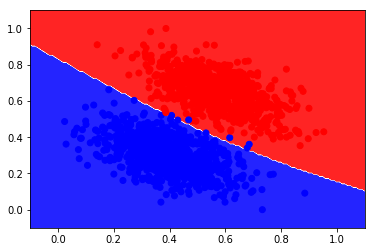


ACCURACY:  0.9975
CONFUSION MATRIX: 
 [[177.   0.]
 [  1. 222.]]


Round: 5
Epoch:1/20	Loss:197.976188	Accuracy:0.670625	Learning rate:0.5	Elapse time[s]:0.483149
Epoch:2/20	Loss:187.214001	Accuracy:0.953750	Learning rate:0.5	Elapse time[s]:0.936918
Epoch:3/20	Loss:181.287114	Accuracy:0.499375	Learning rate:0.5	Elapse time[s]:1.437737
Epoch:4/20	Loss:169.839304	Accuracy:0.995000	Learning rate:0.5	Elapse time[s]:1.875011
Epoch:5/20	Loss:161.038996	Accuracy:0.994375	Learning rate:0.5	Elapse time[s]:2.313091
Epoch:6/20	Loss:152.975703	Accuracy:0.961875	Learning rate:0.5	Elapse time[s]:2.745770
Epoch:7/20	Loss:142.173289	Accuracy:0.993750	Learning rate:0.5	Elapse time[s]:3.227854
Epoch:8/20	Loss:134.429159	Accuracy:0.951250	Learning rate:0.5	Elapse time[s]:3.700121
Epoch:9/20	Loss:126.214541	Accuracy:0.941875	Learning rate:0.5	Elapse time[s]:4.161048
Epoch:10/20	Loss:114.315250	Accuracy:0.990625	Learning rate:0.5	Elapse time[s]:4.623083
Epoch:11/20	Loss:106.928902	Accuracy:0.990625	Learni

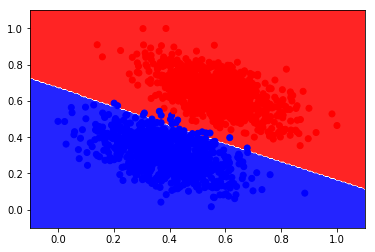


ACCURACY:  0.9875
CONFUSION MATRIX: 
 [[196.   0.]
 [  5. 199.]]



ACCURACY AVERAGE:  0.9925
CONFUSION MATRIX AVERAGE: 
 [[197.   0.]
 [  3. 200.]]


In [71]:
#3. Split data into 5 groups
data_size = X.shape[0]
idx = np.array(range(data_size))
np.random.shuffle(idx)
idx_groups = np.split(idx, 5)
fold_groups = [(X[idxs], y[idxs]) for idxs in idx_groups]
five_sets = set(range(5))

acc_stat = []
con_mat_stat = []
for i in range(len(fold_groups)):
    print("Round: " + str(i+1))
    
    #4. Select test set and train data
    test_group_idx = i
    test_X, test_y = fold_groups[i]
    
    train_group_idx = list(five_sets - {i})
    train_X = [fold_groups[idx][0] for idx in train_group_idx]
    train_y = [fold_groups[idx][1] for idx in train_group_idx]
    
    train_X = np.concatenate(train_X)
    train_y = np.concatenate(train_y)
    
    #5. Initialize model
    NN = NeuralNetwork(2, 5, 1, "sigmoid", "sigmoid", 0.0001, True)
    
    #6. Train the model
    NN.fit(train_X, train_y, 20, 16, 0.5, 0, True)
    loss, acc = NN.calculateError(test_X, test_y)
    
    #6. Plot decision boundary after trainning
    plot_decision_boundary(NN, train_X, train_y)
    
    #7. compute accuracy and confusion matrix
    acc = 0
    y_pred = NN.predict_classify(test_X)
    con_mat = np.zeros((2, 2))
    for i in range(len(y_pred)):
        con_mat[int(y_pred[i]), int(test_y[i][0])] += 1
        if test_y[i] == y_pred[i]:
            acc += 1
    con_mat_stat.append(con_mat)
    
    acc = acc/len(y_pred)
    acc_stat.append(acc)
    
    print('\nACCURACY: ', acc)
    print('CONFUSION MATRIX: \n', con_mat)
    print("\n")
    

print("\nACCURACY AVERAGE: ", np.average(acc_stat))
print("CONFUSION MATRIX AVERAGE: \n", np.average(con_mat_stat, axis=0))


## Non Linear Data (Five fold round robin cross-validation)

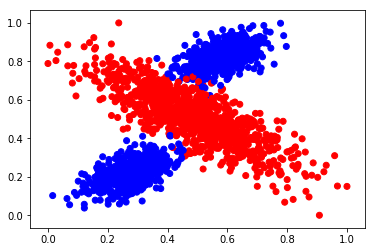

In [72]:
#1. load data
X = np.genfromtxt('DATA/data_nonLinearX.csv', delimiter=',').astype(np.float64)
y = np.genfromtxt('DATA/data_nonLinearY.csv', delimiter=',').astype(np.float64)
y = y.reshape(y.shape[0], 1)

# Normalize X
X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

#2. plot data
plt.scatter(X[:,0], X[:,1], c=[v[0] for v in y], cmap=plt.cm.bwr)
plt.show()

Round: 1
Epoch:1/100	Loss:201.557190	Accuracy:0.493750	Learning rate:0.5	Elapse time[s]:0.440933
Epoch:2/100	Loss:195.812184	Accuracy:0.575000	Learning rate:0.5	Elapse time[s]:0.865187
Epoch:3/100	Loss:192.694837	Accuracy:0.598750	Learning rate:0.5	Elapse time[s]:1.300963
Epoch:4/100	Loss:190.195141	Accuracy:0.646250	Learning rate:0.5	Elapse time[s]:1.796489
Epoch:5/100	Loss:185.105627	Accuracy:0.683125	Learning rate:0.5	Elapse time[s]:2.253148
Epoch:6/100	Loss:183.640518	Accuracy:0.590625	Learning rate:0.5	Elapse time[s]:2.673533
Epoch:7/100	Loss:181.420158	Accuracy:0.660625	Learning rate:0.5	Elapse time[s]:3.089412
Epoch:8/100	Loss:179.950614	Accuracy:0.690000	Learning rate:0.5	Elapse time[s]:3.501413
Epoch:9/100	Loss:178.929827	Accuracy:0.696875	Learning rate:0.5	Elapse time[s]:3.932002
Epoch:10/100	Loss:178.423564	Accuracy:0.707500	Learning rate:0.5	Elapse time[s]:4.362186
Epoch:11/100	Loss:177.488410	Accuracy:0.708750	Learning rate:0.5	Elapse time[s]:4.780773
Epoch:12/100	Loss:177

Epoch:93/100	Loss:94.589306	Accuracy:0.985000	Learning rate:0.5	Elapse time[s]:39.660816
Epoch:94/100	Loss:94.496535	Accuracy:0.969375	Learning rate:0.5	Elapse time[s]:40.095512
Epoch:95/100	Loss:92.238502	Accuracy:0.981875	Learning rate:0.5	Elapse time[s]:40.539331
Epoch:96/100	Loss:94.709450	Accuracy:0.958125	Learning rate:0.5	Elapse time[s]:40.964314
Epoch:97/100	Loss:89.745516	Accuracy:0.980625	Learning rate:0.5	Elapse time[s]:41.377152
Epoch:98/100	Loss:89.194483	Accuracy:0.982500	Learning rate:0.5	Elapse time[s]:41.822912
Epoch:99/100	Loss:87.445858	Accuracy:0.983125	Learning rate:0.5	Elapse time[s]:42.261324
Epoch:100/100	Loss:88.293325	Accuracy:0.974375	Learning rate:0.5	Elapse time[s]:42.738486


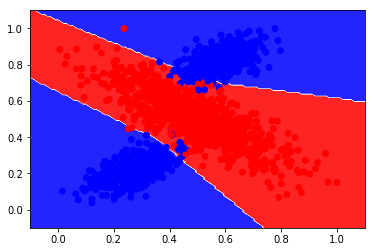


ACCURACY:  0.97
CONFUSION MATRIX: 
 [[178.   0.]
 [ 12. 210.]]


Round: 2
Epoch:1/100	Loss:195.583306	Accuracy:0.681875	Learning rate:0.5	Elapse time[s]:0.428284
Epoch:2/100	Loss:189.450534	Accuracy:0.678125	Learning rate:0.5	Elapse time[s]:0.865694
Epoch:3/100	Loss:182.274855	Accuracy:0.626250	Learning rate:0.5	Elapse time[s]:1.302054
Epoch:4/100	Loss:175.678906	Accuracy:0.670000	Learning rate:0.5	Elapse time[s]:1.718418
Epoch:5/100	Loss:170.425061	Accuracy:0.724375	Learning rate:0.5	Elapse time[s]:2.146977
Epoch:6/100	Loss:166.624766	Accuracy:0.725625	Learning rate:0.5	Elapse time[s]:2.587083
Epoch:7/100	Loss:164.105377	Accuracy:0.742500	Learning rate:0.5	Elapse time[s]:3.013490
Epoch:8/100	Loss:160.869544	Accuracy:0.736250	Learning rate:0.5	Elapse time[s]:3.448709
Epoch:9/100	Loss:158.422463	Accuracy:0.732500	Learning rate:0.5	Elapse time[s]:3.878617
Epoch:10/100	Loss:156.605001	Accuracy:0.745000	Learning rate:0.5	Elapse time[s]:4.325526
Epoch:11/100	Loss:153.011166	Accuracy:0.7425

Epoch:93/100	Loss:93.057945	Accuracy:0.981250	Learning rate:0.5	Elapse time[s]:39.633434
Epoch:94/100	Loss:95.636356	Accuracy:0.958125	Learning rate:0.5	Elapse time[s]:40.049697
Epoch:95/100	Loss:97.830588	Accuracy:0.960625	Learning rate:0.5	Elapse time[s]:40.484068
Epoch:96/100	Loss:93.112765	Accuracy:0.981875	Learning rate:0.5	Elapse time[s]:40.916865
Epoch:97/100	Loss:94.951177	Accuracy:0.966250	Learning rate:0.5	Elapse time[s]:41.340808
Epoch:98/100	Loss:93.498804	Accuracy:0.976250	Learning rate:0.5	Elapse time[s]:41.743570
Epoch:99/100	Loss:92.326653	Accuracy:0.983750	Learning rate:0.5	Elapse time[s]:42.154413
Epoch:100/100	Loss:92.424209	Accuracy:0.981250	Learning rate:0.5	Elapse time[s]:42.570827


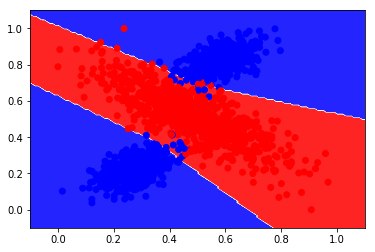


ACCURACY:  0.99
CONFUSION MATRIX: 
 [[194.   0.]
 [  4. 202.]]


Round: 3
Epoch:1/100	Loss:192.103306	Accuracy:0.543125	Learning rate:0.5	Elapse time[s]:0.444449
Epoch:2/100	Loss:190.307906	Accuracy:0.579375	Learning rate:0.5	Elapse time[s]:0.864754
Epoch:3/100	Loss:186.743638	Accuracy:0.747500	Learning rate:0.5	Elapse time[s]:1.299941
Epoch:4/100	Loss:181.850649	Accuracy:0.770000	Learning rate:0.5	Elapse time[s]:1.722597
Epoch:5/100	Loss:176.775851	Accuracy:0.783750	Learning rate:0.5	Elapse time[s]:2.139418
Epoch:6/100	Loss:171.406021	Accuracy:0.770625	Learning rate:0.5	Elapse time[s]:2.588732
Epoch:7/100	Loss:166.739517	Accuracy:0.695000	Learning rate:0.5	Elapse time[s]:2.999170
Epoch:8/100	Loss:162.220271	Accuracy:0.663750	Learning rate:0.5	Elapse time[s]:3.411747
Epoch:9/100	Loss:159.116473	Accuracy:0.794375	Learning rate:0.5	Elapse time[s]:3.824239
Epoch:10/100	Loss:157.601855	Accuracy:0.735000	Learning rate:0.5	Elapse time[s]:4.232035
Epoch:11/100	Loss:153.153575	Accuracy:0.7325

Epoch:93/100	Loss:84.284956	Accuracy:0.983125	Learning rate:0.5	Elapse time[s]:39.461345
Epoch:94/100	Loss:85.269077	Accuracy:0.973750	Learning rate:0.5	Elapse time[s]:39.892696
Epoch:95/100	Loss:84.579530	Accuracy:0.986875	Learning rate:0.5	Elapse time[s]:40.302266
Epoch:96/100	Loss:85.002819	Accuracy:0.984375	Learning rate:0.5	Elapse time[s]:40.708926
Epoch:97/100	Loss:84.188463	Accuracy:0.985625	Learning rate:0.5	Elapse time[s]:41.111821
Epoch:98/100	Loss:84.470856	Accuracy:0.981875	Learning rate:0.5	Elapse time[s]:41.530970
Epoch:99/100	Loss:84.221801	Accuracy:0.986250	Learning rate:0.5	Elapse time[s]:41.931555
Epoch:100/100	Loss:83.900873	Accuracy:0.983125	Learning rate:0.5	Elapse time[s]:42.329988


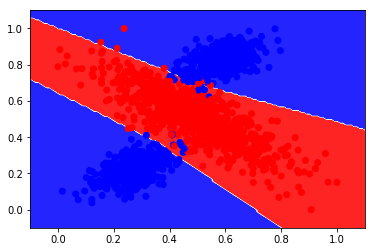


ACCURACY:  0.98
CONFUSION MATRIX: 
 [[197.   2.]
 [  6. 195.]]


Round: 4
Epoch:1/100	Loss:202.265486	Accuracy:0.263750	Learning rate:0.5	Elapse time[s]:0.456184
Epoch:2/100	Loss:198.466879	Accuracy:0.480625	Learning rate:0.5	Elapse time[s]:0.873486
Epoch:3/100	Loss:197.576131	Accuracy:0.595625	Learning rate:0.5	Elapse time[s]:1.282168
Epoch:4/100	Loss:195.649538	Accuracy:0.644375	Learning rate:0.5	Elapse time[s]:1.685697
Epoch:5/100	Loss:193.023458	Accuracy:0.816250	Learning rate:0.5	Elapse time[s]:2.111719
Epoch:6/100	Loss:190.459795	Accuracy:0.721250	Learning rate:0.5	Elapse time[s]:2.539891
Epoch:7/100	Loss:186.696875	Accuracy:0.832500	Learning rate:0.5	Elapse time[s]:2.955643
Epoch:8/100	Loss:182.507714	Accuracy:0.765625	Learning rate:0.5	Elapse time[s]:3.387633
Epoch:9/100	Loss:179.693284	Accuracy:0.738750	Learning rate:0.5	Elapse time[s]:3.792125
Epoch:10/100	Loss:174.102034	Accuracy:0.896875	Learning rate:0.5	Elapse time[s]:4.202422
Epoch:11/100	Loss:170.768109	Accuracy:0.7350

Epoch:92/100	Loss:131.500658	Accuracy:0.906875	Learning rate:0.5	Elapse time[s]:39.078485
Epoch:93/100	Loss:132.505239	Accuracy:0.932500	Learning rate:0.5	Elapse time[s]:39.494675
Epoch:94/100	Loss:131.776814	Accuracy:0.933125	Learning rate:0.5	Elapse time[s]:39.926186
Epoch:95/100	Loss:133.401802	Accuracy:0.961250	Learning rate:0.5	Elapse time[s]:40.357759
Epoch:96/100	Loss:131.920803	Accuracy:0.943125	Learning rate:0.5	Elapse time[s]:40.775257
Epoch:97/100	Loss:132.515270	Accuracy:0.926250	Learning rate:0.5	Elapse time[s]:41.190920
Epoch:98/100	Loss:133.347994	Accuracy:0.905625	Learning rate:0.5	Elapse time[s]:41.601280
Epoch:99/100	Loss:132.310453	Accuracy:0.918125	Learning rate:0.5	Elapse time[s]:42.001330
Epoch:100/100	Loss:133.651597	Accuracy:0.962500	Learning rate:0.5	Elapse time[s]:42.434402


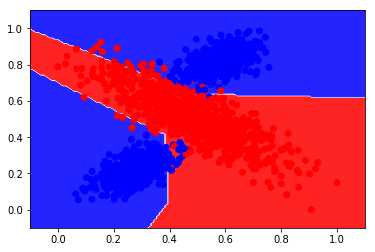


ACCURACY:  0.955
CONFUSION MATRIX: 
 [[191.  14.]
 [  4. 191.]]


Round: 5
Epoch:1/100	Loss:200.852396	Accuracy:0.470000	Learning rate:0.5	Elapse time[s]:0.469429
Epoch:2/100	Loss:191.368852	Accuracy:0.720000	Learning rate:0.5	Elapse time[s]:0.892096
Epoch:3/100	Loss:185.173102	Accuracy:0.607500	Learning rate:0.5	Elapse time[s]:1.317406
Epoch:4/100	Loss:177.438396	Accuracy:0.949375	Learning rate:0.5	Elapse time[s]:1.743736
Epoch:5/100	Loss:171.247472	Accuracy:0.856250	Learning rate:0.5	Elapse time[s]:2.164596
Epoch:6/100	Loss:166.879458	Accuracy:0.931250	Learning rate:0.5	Elapse time[s]:2.587144
Epoch:7/100	Loss:161.958152	Accuracy:0.905000	Learning rate:0.5	Elapse time[s]:3.028961
Epoch:8/100	Loss:159.037517	Accuracy:0.888750	Learning rate:0.5	Elapse time[s]:3.466542
Epoch:9/100	Loss:155.220501	Accuracy:0.952500	Learning rate:0.5	Elapse time[s]:3.874658
Epoch:10/100	Loss:148.441635	Accuracy:0.828125	Learning rate:0.5	Elapse time[s]:4.299003
Epoch:11/100	Loss:140.004930	Accuracy:0.903

Epoch:93/100	Loss:83.348993	Accuracy:0.987500	Learning rate:0.5	Elapse time[s]:39.715174
Epoch:94/100	Loss:83.640190	Accuracy:0.975625	Learning rate:0.5	Elapse time[s]:40.139098
Epoch:95/100	Loss:83.207606	Accuracy:0.984375	Learning rate:0.5	Elapse time[s]:40.569777
Epoch:96/100	Loss:84.625129	Accuracy:0.972500	Learning rate:0.5	Elapse time[s]:40.999243
Epoch:97/100	Loss:83.932893	Accuracy:0.985625	Learning rate:0.5	Elapse time[s]:41.439021
Epoch:98/100	Loss:83.583543	Accuracy:0.985000	Learning rate:0.5	Elapse time[s]:41.871607
Epoch:99/100	Loss:84.707308	Accuracy:0.970000	Learning rate:0.5	Elapse time[s]:42.289590
Epoch:100/100	Loss:83.262342	Accuracy:0.981875	Learning rate:0.5	Elapse time[s]:42.726684


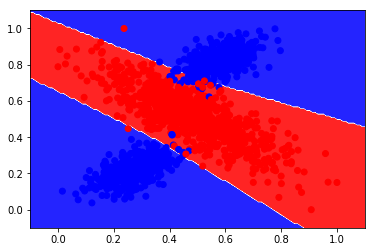


ACCURACY:  0.9725
CONFUSION MATRIX: 
 [[204.   1.]
 [ 10. 185.]]



ACCURACY AVERAGE:  0.9734999999999999
CONFUSION MATRIX AVERAGE: 
 [[192.8   3.4]
 [  7.2 196.6]]


In [82]:
#3. Split data into 5 groups
data_size = X.shape[0]
idx = np.array(range(data_size))
np.random.shuffle(idx)
idx_groups = np.split(idx, 5)
fold_groups = [(X[idxs], y[idxs]) for idxs in idx_groups]
five_sets = set(range(5))

acc_stat = []
con_mat_stat = []
for i in range(len(fold_groups)):
    print("Round: " + str(i+1))
    
    #4. Select test set and train data
    test_group_idx = i
    test_X, test_y = fold_groups[i]
    
    train_group_idx = list(five_sets - {i})
    train_X = [fold_groups[idx][0] for idx in train_group_idx]
    train_y = [fold_groups[idx][1] for idx in train_group_idx]
    
    train_X = np.concatenate(train_X)
    train_y = np.concatenate(train_y)
    
    #5. Initialize model
    NN = NeuralNetwork(2, 7, 1, "ReLU", "sigmoid", 0.001, True)
    
    #6. Train the model
    NN.fit(train_X, train_y, 100, 16, 0.5, 0, True)
    loss, acc = NN.calculateError(test_X, test_y)
    
    #6. Plot decision boundary after trainning
    plot_decision_boundary(NN, train_X, train_y)
    
    #7. compute accuracy and confusion matrix
    acc = 0
    y_pred = NN.predict_classify(test_X)
    con_mat = np.zeros((2, 2))
    for i in range(len(y_pred)):
        con_mat[int(y_pred[i]), int(test_y[i][0])] += 1
        if test_y[i] == y_pred[i]:
            acc += 1
    con_mat_stat.append(con_mat)
    
    acc = acc/len(y_pred)
    acc_stat.append(acc)
    
    print('\nACCURACY: ', acc)
    print('CONFUSION MATRIX: \n', con_mat)
    print("\n")
    

print("\nACCURACY AVERAGE: ", np.average(acc_stat))
print("CONFUSION MATRIX AVERAGE: \n", np.average(con_mat_stat, axis=0))


## The effect of learning rate

In [125]:
# Load data
X = np.genfromtxt('DATA/data_nonLinearX.csv', delimiter=',').astype(np.float64)
y = np.genfromtxt('DATA/data_nonLinearY.csv', delimiter=',').astype(np.float64)
y = y.reshape(y.shape[0], 1)

# Normalize X
X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

In [104]:
NN = NeuralNetwork(2, 5, 1, "sigmoid", "sigmoid", 0.0001, True)
wih = NN.wih.copy()
who = NN.who.copy()

data_for_plot = []
for rate in np.linspace(0.1, 100, 20):
    NN = NeuralNetwork(2, 5, 1, "sigmoid", "sigmoid", 0.0001, True)
    NN.wih = wih.copy()
    NN.who = who.copy()
    #6. Train the model
    NN.fit(X, y, 20, 16, rate, 0, False)
    loss, acc = NN.calculateError(X, y)
    data_for_plot.append((rate, loss, acc))
    print(rate, loss, acc)

0.1 247.30382864388497 0.624
5.3578947368421055 120.47851572498264 0.8235
10.615789473684211 30.40220647788731 0.982
15.873684210526317 19.51500257766669 0.978
21.131578947368425 21.557903708891047 0.975
26.38947368421053 13.959256567241157 0.984
31.647368421052636 15.276307931310898 0.983
36.905263157894744 23.61482494306436 0.9785
42.16315789473685 255.2485001737934 0.7445
47.42105263157895 16.370550245408282 0.981
52.678947368421056 16.271146820458572 0.9825
57.93684210526317 259.5843402990314 0.74
63.19473684210527 261.99725115078047 0.7405
68.45263157894738 501.3497583127228 0.5
73.71052631578948 256.6630011737556 0.744
78.96842105263158 501.46710463173775 0.5
84.22631578947369 265.49091866986566 0.733
89.48421052631579 268.99176620992347 0.7315
94.7421052631579 500.57501027714767 0.5
100.0 500.1428015137376 0.5


In [112]:
import prettytable as pt
tb = pt.PrettyTable()
tb.field_names = ["Learning Rate", "Loss", "Accuracy"]

for d in data_for_plot:

    tb.add_row(d)
    
print(tb)

+--------------------+--------------------+----------+
|   Learning Rate    |        Loss        | Accuracy |
+--------------------+--------------------+----------+
|        0.1         | 247.30382864388497 |  0.624   |
| 5.3578947368421055 | 120.47851572498264 |  0.8235  |
| 10.615789473684211 | 30.40220647788731  |  0.982   |
| 15.873684210526317 | 19.51500257766669  |  0.978   |
| 21.131578947368425 | 21.557903708891047 |  0.975   |
| 26.38947368421053  | 13.959256567241157 |  0.984   |
| 31.647368421052636 | 15.276307931310898 |  0.983   |
| 36.905263157894744 | 23.61482494306436  |  0.9785  |
| 42.16315789473685  | 255.2485001737934  |  0.7445  |
| 47.42105263157895  | 16.370550245408282 |  0.981   |
| 52.678947368421056 | 16.271146820458572 |  0.9825  |
| 57.93684210526317  | 259.5843402990314  |   0.74   |
| 63.19473684210527  | 261.99725115078047 |  0.7405  |
| 68.45263157894738  | 501.3497583127228  |   0.5    |
| 73.71052631578948  | 256.6630011737556  |  0.744   |
| 78.96842

Text(0, 0.5, 'Accuracy')

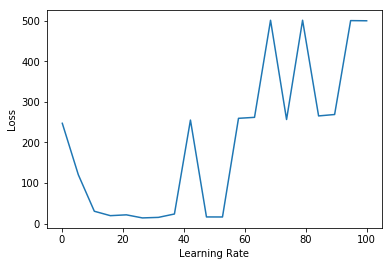

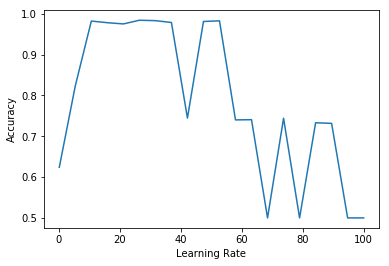

In [110]:
x = [d[0] for d in data_for_plot]
loss = [d[1] for d in data_for_plot]
accuracy = [d[2] for d in data_for_plot]

plt.figure()
plt.plot(x, loss)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')


plt.figure()
plt.plot(x, accuracy)
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

In [142]:
NN = NeuralNetwork(2, 5, 1, "sigmoid", "sigmoid", 0.0001, True)
wih = NN.wih.copy()
who = NN.who.copy()

learn_rate_list = [0.5, 5, 20, 50]
learn_rate_epoch_loss = {0.5:[], 5:[], 20:[], 50:[]}

for rate in learn_rate_list:
    NN = NeuralNetwork(2, 5, 1, "sigmoid", "sigmoid", 0.0001, True)
    NN.wih = wih.copy()
    NN.who = who.copy()
    
    #6. Train the model
    epoch_loss = NN.fit(X, y, 20, 16, rate, 0, True)
    learn_rate_epoch_loss[rate] = epoch_loss
   

Epoch:1/20	Loss:253.939191	Accuracy:0.500000	Learning rate:0.5	Elapse time[s]:0.543717
Epoch:2/20	Loss:246.593532	Accuracy:0.518500	Learning rate:0.5	Elapse time[s]:1.112333
Epoch:3/20	Loss:245.801938	Accuracy:0.664000	Learning rate:0.5	Elapse time[s]:1.661779
Epoch:4/20	Loss:243.696870	Accuracy:0.556000	Learning rate:0.5	Elapse time[s]:2.255904
Epoch:5/20	Loss:242.965143	Accuracy:0.663500	Learning rate:0.5	Elapse time[s]:2.823422
Epoch:6/20	Loss:242.580516	Accuracy:0.711500	Learning rate:0.5	Elapse time[s]:3.366258
Epoch:7/20	Loss:244.950944	Accuracy:0.500000	Learning rate:0.5	Elapse time[s]:3.909742
Epoch:8/20	Loss:241.894347	Accuracy:0.718500	Learning rate:0.5	Elapse time[s]:4.442023
Epoch:9/20	Loss:241.447410	Accuracy:0.700500	Learning rate:0.5	Elapse time[s]:4.990731
Epoch:10/20	Loss:241.017306	Accuracy:0.647000	Learning rate:0.5	Elapse time[s]:5.568637
Epoch:11/20	Loss:240.769277	Accuracy:0.717500	Learning rate:0.5	Elapse time[s]:6.134046
Epoch:12/20	Loss:240.345640	Accuracy:0.65

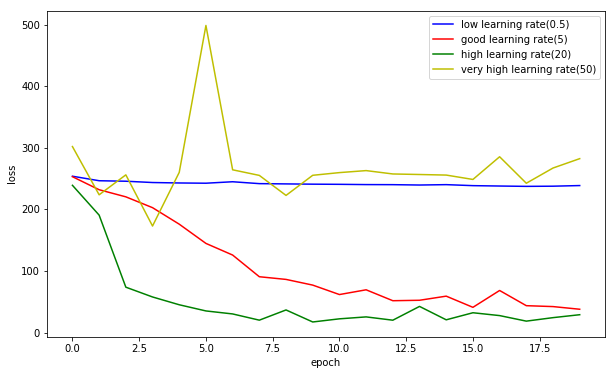

In [144]:
plt.figure(figsize=(10,6))
plt.plot(range(20), learn_rate_epoch_loss[0.5], color='b', label="low learning rate(0.5)")
plt.plot(range(20), learn_rate_epoch_loss[5], color='r', label="good learning rate(5)")
plt.plot(range(20), learn_rate_epoch_loss[20], color='g', label="high learning rate(20)")
plt.plot(range(20), learn_rate_epoch_loss[50], color='y', label="very high learning rate(50)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()


## L2 regularization

In [115]:
#1. load data
X = np.genfromtxt('DATA/data_nonLinearX.csv', delimiter=',').astype(np.float64)
y = np.genfromtxt('DATA/data_nonLinearY.csv', delimiter=',').astype(np.float64)
y = y.reshape(y.shape[0], 1)

# Normalize X
X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

Round: 1
Epoch:1/100	Loss:202.299333	Accuracy:0.465000	Learning rate:1.0	Elapse time[s]:0.407674
Epoch:2/100	Loss:197.456291	Accuracy:0.483750	Learning rate:1.0	Elapse time[s]:0.812349
Epoch:3/100	Loss:195.213099	Accuracy:0.531875	Learning rate:1.0	Elapse time[s]:1.199281
Epoch:4/100	Loss:194.728682	Accuracy:0.565000	Learning rate:1.0	Elapse time[s]:1.591118
Epoch:5/100	Loss:195.254848	Accuracy:0.603125	Learning rate:1.0	Elapse time[s]:1.984180
Epoch:6/100	Loss:196.691014	Accuracy:0.564375	Learning rate:1.0	Elapse time[s]:2.374937
Epoch:7/100	Loss:193.845886	Accuracy:0.606250	Learning rate:1.0	Elapse time[s]:2.761215
Epoch:8/100	Loss:196.635116	Accuracy:0.505625	Learning rate:1.0	Elapse time[s]:3.151323
Epoch:9/100	Loss:192.411703	Accuracy:0.603750	Learning rate:1.0	Elapse time[s]:3.547992
Epoch:10/100	Loss:192.641156	Accuracy:0.590625	Learning rate:1.0	Elapse time[s]:3.929494
Epoch:11/100	Loss:193.691209	Accuracy:0.534375	Learning rate:1.0	Elapse time[s]:4.332438
Epoch:12/100	Loss:189

Epoch:93/100	Loss:126.926646	Accuracy:0.783750	Learning rate:1.0	Elapse time[s]:36.994390
Epoch:94/100	Loss:126.051068	Accuracy:0.783750	Learning rate:1.0	Elapse time[s]:37.386300
Epoch:95/100	Loss:131.868197	Accuracy:0.770000	Learning rate:1.0	Elapse time[s]:37.784295
Epoch:96/100	Loss:125.135924	Accuracy:0.784375	Learning rate:1.0	Elapse time[s]:38.170748
Epoch:97/100	Loss:129.001180	Accuracy:0.783750	Learning rate:1.0	Elapse time[s]:38.560904
Epoch:98/100	Loss:128.742381	Accuracy:0.781875	Learning rate:1.0	Elapse time[s]:38.940210
Epoch:99/100	Loss:126.161616	Accuracy:0.783750	Learning rate:1.0	Elapse time[s]:39.316384
Epoch:100/100	Loss:124.706630	Accuracy:0.784375	Learning rate:1.0	Elapse time[s]:39.695843
Epoch:1/100	Loss:202.193978	Accuracy:0.489375	Learning rate:1.0	Elapse time[s]:0.400187
Epoch:2/100	Loss:197.097228	Accuracy:0.496250	Learning rate:1.0	Elapse time[s]:0.793560
Epoch:3/100	Loss:195.502383	Accuracy:0.540625	Learning rate:1.0	Elapse time[s]:1.225766
Epoch:4/100	Los

Epoch:85/100	Loss:67.193363	Accuracy:0.970625	Learning rate:1.0	Elapse time[s]:36.008892
Epoch:86/100	Loss:60.947162	Accuracy:0.968750	Learning rate:1.0	Elapse time[s]:36.444743
Epoch:87/100	Loss:56.855324	Accuracy:0.974375	Learning rate:1.0	Elapse time[s]:36.877133
Epoch:88/100	Loss:54.467846	Accuracy:0.976250	Learning rate:1.0	Elapse time[s]:37.289497
Epoch:89/100	Loss:51.512626	Accuracy:0.970625	Learning rate:1.0	Elapse time[s]:37.722955
Epoch:90/100	Loss:50.745877	Accuracy:0.975625	Learning rate:1.0	Elapse time[s]:38.164142
Epoch:91/100	Loss:47.653481	Accuracy:0.982500	Learning rate:1.0	Elapse time[s]:38.564979
Epoch:92/100	Loss:44.758876	Accuracy:0.981875	Learning rate:1.0	Elapse time[s]:39.011589
Epoch:93/100	Loss:41.560001	Accuracy:0.976250	Learning rate:1.0	Elapse time[s]:39.420052
Epoch:94/100	Loss:41.699579	Accuracy:0.985000	Learning rate:1.0	Elapse time[s]:39.822294
Epoch:95/100	Loss:41.580060	Accuracy:0.980625	Learning rate:1.0	Elapse time[s]:40.268484
Epoch:96/100	Loss:41.

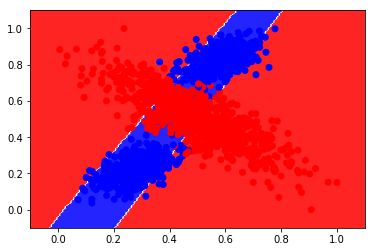

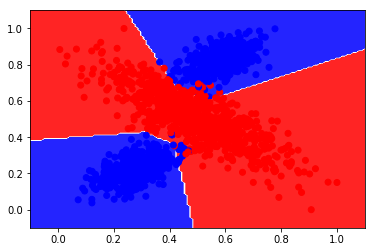


ACCURACY Normal:  0.7525
CONFUSION MATRIX Normal: 
 [[180.  82.]
 [ 17. 121.]]



ACCURACY Regularize:  0.98
CONFUSION MATRIX Regularize: 
 [[196.   7.]
 [  1. 196.]]


Round: 2
Epoch:1/100	Loss:191.350542	Accuracy:0.604375	Learning rate:1.0	Elapse time[s]:0.483182
Epoch:2/100	Loss:179.831260	Accuracy:0.663125	Learning rate:1.0	Elapse time[s]:0.866261
Epoch:3/100	Loss:162.335918	Accuracy:0.788750	Learning rate:1.0	Elapse time[s]:1.256014
Epoch:4/100	Loss:145.558123	Accuracy:0.913125	Learning rate:1.0	Elapse time[s]:1.645528
Epoch:5/100	Loss:126.719493	Accuracy:0.955000	Learning rate:1.0	Elapse time[s]:2.038552
Epoch:6/100	Loss:115.031209	Accuracy:0.935625	Learning rate:1.0	Elapse time[s]:2.415288
Epoch:7/100	Loss:94.496581	Accuracy:0.960625	Learning rate:1.0	Elapse time[s]:2.820588
Epoch:8/100	Loss:86.132137	Accuracy:0.961875	Learning rate:1.0	Elapse time[s]:3.197717
Epoch:9/100	Loss:81.822914	Accuracy:0.937500	Learning rate:1.0	Elapse time[s]:3.613875
Epoch:10/100	Loss:71.201709	Accu

Epoch:92/100	Loss:13.143043	Accuracy:0.985625	Learning rate:1.0	Elapse time[s]:36.628174
Epoch:93/100	Loss:12.051860	Accuracy:0.988750	Learning rate:1.0	Elapse time[s]:36.999530
Epoch:94/100	Loss:11.559742	Accuracy:0.985000	Learning rate:1.0	Elapse time[s]:37.379769
Epoch:95/100	Loss:11.203299	Accuracy:0.985000	Learning rate:1.0	Elapse time[s]:37.775568
Epoch:96/100	Loss:11.490957	Accuracy:0.985625	Learning rate:1.0	Elapse time[s]:38.166799
Epoch:97/100	Loss:12.221237	Accuracy:0.986250	Learning rate:1.0	Elapse time[s]:38.543939
Epoch:98/100	Loss:11.731502	Accuracy:0.987500	Learning rate:1.0	Elapse time[s]:38.924830
Epoch:99/100	Loss:11.193413	Accuracy:0.985000	Learning rate:1.0	Elapse time[s]:39.309999
Epoch:100/100	Loss:11.161517	Accuracy:0.987500	Learning rate:1.0	Elapse time[s]:39.697857
Epoch:1/100	Loss:191.986928	Accuracy:0.605000	Learning rate:1.0	Elapse time[s]:0.418570
Epoch:2/100	Loss:177.454252	Accuracy:0.746875	Learning rate:1.0	Elapse time[s]:0.819645
Epoch:3/100	Loss:163.3

Epoch:85/100	Loss:17.073325	Accuracy:0.985625	Learning rate:1.0	Elapse time[s]:35.928660
Epoch:86/100	Loss:16.245096	Accuracy:0.984375	Learning rate:1.0	Elapse time[s]:36.335083
Epoch:87/100	Loss:15.637747	Accuracy:0.984375	Learning rate:1.0	Elapse time[s]:36.761066
Epoch:88/100	Loss:16.415978	Accuracy:0.985625	Learning rate:1.0	Elapse time[s]:37.191373
Epoch:89/100	Loss:15.737784	Accuracy:0.986875	Learning rate:1.0	Elapse time[s]:37.617170
Epoch:90/100	Loss:16.048233	Accuracy:0.983750	Learning rate:1.0	Elapse time[s]:38.022757
Epoch:91/100	Loss:15.928234	Accuracy:0.987500	Learning rate:1.0	Elapse time[s]:38.442819
Epoch:92/100	Loss:15.186052	Accuracy:0.985625	Learning rate:1.0	Elapse time[s]:38.848741
Epoch:93/100	Loss:15.384800	Accuracy:0.984375	Learning rate:1.0	Elapse time[s]:39.276773
Epoch:94/100	Loss:15.467264	Accuracy:0.988125	Learning rate:1.0	Elapse time[s]:39.693359
Epoch:95/100	Loss:15.543768	Accuracy:0.985625	Learning rate:1.0	Elapse time[s]:40.125755
Epoch:96/100	Loss:16.

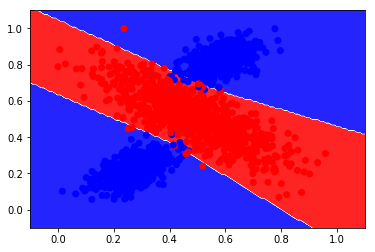

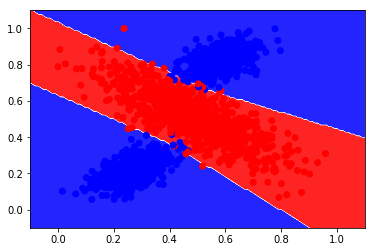


ACCURACY Normal:  0.9775
CONFUSION MATRIX Normal: 
 [[191.   2.]
 [  7. 200.]]



ACCURACY Regularize:  0.9825
CONFUSION MATRIX Regularize: 
 [[193.   2.]
 [  5. 200.]]


Round: 3
Epoch:1/100	Loss:190.031002	Accuracy:0.695625	Learning rate:1.0	Elapse time[s]:0.391594
Epoch:2/100	Loss:184.383418	Accuracy:0.506875	Learning rate:1.0	Elapse time[s]:0.787728
Epoch:3/100	Loss:175.113507	Accuracy:0.711250	Learning rate:1.0	Elapse time[s]:1.191256
Epoch:4/100	Loss:168.503522	Accuracy:0.768750	Learning rate:1.0	Elapse time[s]:1.580573
Epoch:5/100	Loss:164.587811	Accuracy:0.756875	Learning rate:1.0	Elapse time[s]:1.991721
Epoch:6/100	Loss:160.777486	Accuracy:0.773125	Learning rate:1.0	Elapse time[s]:2.389424
Epoch:7/100	Loss:157.943772	Accuracy:0.749375	Learning rate:1.0	Elapse time[s]:2.784556
Epoch:8/100	Loss:154.165944	Accuracy:0.764375	Learning rate:1.0	Elapse time[s]:3.182780
Epoch:9/100	Loss:152.595443	Accuracy:0.770625	Learning rate:1.0	Elapse time[s]:3.612097
Epoch:10/100	Loss:152.42834

Epoch:91/100	Loss:127.489626	Accuracy:0.778125	Learning rate:1.0	Elapse time[s]:36.288550
Epoch:92/100	Loss:131.370505	Accuracy:0.765625	Learning rate:1.0	Elapse time[s]:36.665482
Epoch:93/100	Loss:127.421557	Accuracy:0.778750	Learning rate:1.0	Elapse time[s]:37.102860
Epoch:94/100	Loss:128.566144	Accuracy:0.777500	Learning rate:1.0	Elapse time[s]:37.543119
Epoch:95/100	Loss:127.955082	Accuracy:0.778125	Learning rate:1.0	Elapse time[s]:37.980097
Epoch:96/100	Loss:128.563779	Accuracy:0.777500	Learning rate:1.0	Elapse time[s]:38.381173
Epoch:97/100	Loss:131.228667	Accuracy:0.766875	Learning rate:1.0	Elapse time[s]:38.752086
Epoch:98/100	Loss:131.834721	Accuracy:0.765000	Learning rate:1.0	Elapse time[s]:39.131347
Epoch:99/100	Loss:128.856272	Accuracy:0.767500	Learning rate:1.0	Elapse time[s]:39.534743
Epoch:100/100	Loss:128.663082	Accuracy:0.769375	Learning rate:1.0	Elapse time[s]:39.920763
Epoch:1/100	Loss:190.292308	Accuracy:0.556875	Learning rate:1.0	Elapse time[s]:0.416493
Epoch:2/100

Epoch:83/100	Loss:138.034128	Accuracy:0.754375	Learning rate:1.0	Elapse time[s]:35.712001
Epoch:84/100	Loss:133.743717	Accuracy:0.767500	Learning rate:1.0	Elapse time[s]:36.146151
Epoch:85/100	Loss:131.249913	Accuracy:0.777500	Learning rate:1.0	Elapse time[s]:36.540996
Epoch:86/100	Loss:140.152299	Accuracy:0.753750	Learning rate:1.0	Elapse time[s]:36.955795
Epoch:87/100	Loss:131.831934	Accuracy:0.778125	Learning rate:1.0	Elapse time[s]:37.399897
Epoch:88/100	Loss:130.008787	Accuracy:0.776875	Learning rate:1.0	Elapse time[s]:37.813902
Epoch:89/100	Loss:131.664784	Accuracy:0.772500	Learning rate:1.0	Elapse time[s]:38.234053
Epoch:90/100	Loss:132.613842	Accuracy:0.773750	Learning rate:1.0	Elapse time[s]:38.628296
Epoch:91/100	Loss:132.429479	Accuracy:0.768750	Learning rate:1.0	Elapse time[s]:39.043875
Epoch:92/100	Loss:131.025756	Accuracy:0.778750	Learning rate:1.0	Elapse time[s]:39.484781
Epoch:93/100	Loss:131.571410	Accuracy:0.773750	Learning rate:1.0	Elapse time[s]:39.877120
Epoch:94/1

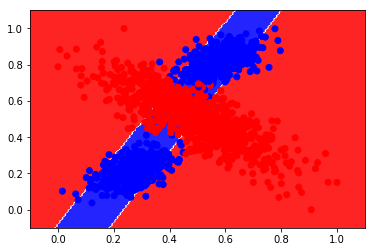

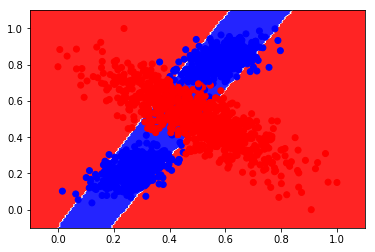


ACCURACY Normal:  0.78
CONFUSION MATRIX Normal: 
 [[177.  54.]
 [ 34. 135.]]



ACCURACY Regularize:  0.7725
CONFUSION MATRIX Regularize: 
 [[189.  69.]
 [ 22. 120.]]


Round: 4
Epoch:1/100	Loss:213.089219	Accuracy:0.496250	Learning rate:1.0	Elapse time[s]:0.467463
Epoch:2/100	Loss:202.992907	Accuracy:0.528125	Learning rate:1.0	Elapse time[s]:0.870153
Epoch:3/100	Loss:195.589673	Accuracy:0.583125	Learning rate:1.0	Elapse time[s]:1.252006
Epoch:4/100	Loss:195.170466	Accuracy:0.496250	Learning rate:1.0	Elapse time[s]:1.636901
Epoch:5/100	Loss:196.197846	Accuracy:0.561875	Learning rate:1.0	Elapse time[s]:2.035688
Epoch:6/100	Loss:196.296089	Accuracy:0.496250	Learning rate:1.0	Elapse time[s]:2.437405
Epoch:7/100	Loss:192.961525	Accuracy:0.590625	Learning rate:1.0	Elapse time[s]:2.823183
Epoch:8/100	Loss:191.938179	Accuracy:0.629375	Learning rate:1.0	Elapse time[s]:3.208522
Epoch:9/100	Loss:190.917377	Accuracy:0.592500	Learning rate:1.0	Elapse time[s]:3.633368
Epoch:10/100	Loss:190.179280	

Epoch:91/100	Loss:131.314958	Accuracy:0.770000	Learning rate:1.0	Elapse time[s]:36.029266
Epoch:92/100	Loss:129.962673	Accuracy:0.768750	Learning rate:1.0	Elapse time[s]:36.460943
Epoch:93/100	Loss:127.000797	Accuracy:0.772500	Learning rate:1.0	Elapse time[s]:36.834839
Epoch:94/100	Loss:134.811020	Accuracy:0.771875	Learning rate:1.0	Elapse time[s]:37.253320
Epoch:95/100	Loss:134.596025	Accuracy:0.764375	Learning rate:1.0	Elapse time[s]:37.640026
Epoch:96/100	Loss:132.471898	Accuracy:0.763750	Learning rate:1.0	Elapse time[s]:38.073453
Epoch:97/100	Loss:133.025686	Accuracy:0.763750	Learning rate:1.0	Elapse time[s]:38.487875
Epoch:98/100	Loss:134.980028	Accuracy:0.765000	Learning rate:1.0	Elapse time[s]:38.875096
Epoch:99/100	Loss:130.599072	Accuracy:0.775000	Learning rate:1.0	Elapse time[s]:39.272619
Epoch:100/100	Loss:128.275459	Accuracy:0.776250	Learning rate:1.0	Elapse time[s]:39.671087
Epoch:1/100	Loss:203.086505	Accuracy:0.365625	Learning rate:1.0	Elapse time[s]:0.428031
Epoch:2/100

Epoch:83/100	Loss:136.526411	Accuracy:0.764375	Learning rate:1.0	Elapse time[s]:35.381470
Epoch:84/100	Loss:133.056997	Accuracy:0.775000	Learning rate:1.0	Elapse time[s]:35.795156
Epoch:85/100	Loss:135.394319	Accuracy:0.766250	Learning rate:1.0	Elapse time[s]:36.206639
Epoch:86/100	Loss:135.816497	Accuracy:0.765000	Learning rate:1.0	Elapse time[s]:36.625327
Epoch:87/100	Loss:134.364570	Accuracy:0.775625	Learning rate:1.0	Elapse time[s]:37.051502
Epoch:88/100	Loss:132.872500	Accuracy:0.768125	Learning rate:1.0	Elapse time[s]:37.459333
Epoch:89/100	Loss:133.116110	Accuracy:0.780625	Learning rate:1.0	Elapse time[s]:37.875980
Epoch:90/100	Loss:139.628503	Accuracy:0.754375	Learning rate:1.0	Elapse time[s]:38.305423
Epoch:91/100	Loss:132.827864	Accuracy:0.773750	Learning rate:1.0	Elapse time[s]:38.711611
Epoch:92/100	Loss:134.711760	Accuracy:0.767500	Learning rate:1.0	Elapse time[s]:39.178217
Epoch:93/100	Loss:132.286023	Accuracy:0.770000	Learning rate:1.0	Elapse time[s]:39.667999
Epoch:94/1

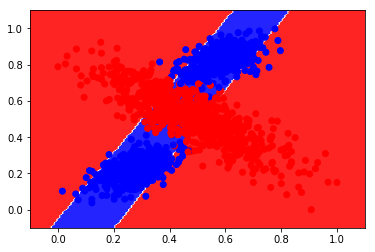

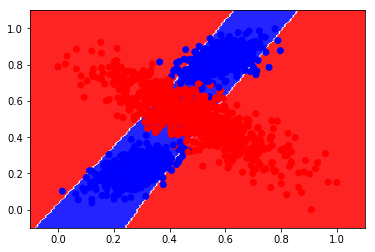


ACCURACY Normal:  0.79
CONFUSION MATRIX Normal: 
 [[183.  73.]
 [ 11. 133.]]



ACCURACY Regularize:  0.78
CONFUSION MATRIX Regularize: 
 [[185.  79.]
 [  9. 127.]]


Round: 5
Epoch:1/100	Loss:158.481431	Accuracy:0.959375	Learning rate:1.0	Elapse time[s]:0.458455
Epoch:2/100	Loss:134.109770	Accuracy:0.956250	Learning rate:1.0	Elapse time[s]:0.859653
Epoch:3/100	Loss:108.854937	Accuracy:0.968125	Learning rate:1.0	Elapse time[s]:1.246427
Epoch:4/100	Loss:91.647407	Accuracy:0.971875	Learning rate:1.0	Elapse time[s]:1.663694
Epoch:5/100	Loss:79.166469	Accuracy:0.977500	Learning rate:1.0	Elapse time[s]:2.077410
Epoch:6/100	Loss:68.478201	Accuracy:0.979375	Learning rate:1.0	Elapse time[s]:2.482429
Epoch:7/100	Loss:63.378363	Accuracy:0.971250	Learning rate:1.0	Elapse time[s]:2.890987
Epoch:8/100	Loss:55.473443	Accuracy:0.983125	Learning rate:1.0	Elapse time[s]:3.289936
Epoch:9/100	Loss:50.384620	Accuracy:0.982500	Learning rate:1.0	Elapse time[s]:3.687247
Epoch:10/100	Loss:47.137057	Accuracy:

Epoch:92/100	Loss:17.740105	Accuracy:0.983750	Learning rate:1.0	Elapse time[s]:37.008615
Epoch:93/100	Loss:18.833706	Accuracy:0.980625	Learning rate:1.0	Elapse time[s]:37.388984
Epoch:94/100	Loss:17.531644	Accuracy:0.983750	Learning rate:1.0	Elapse time[s]:37.764589
Epoch:95/100	Loss:17.349366	Accuracy:0.981875	Learning rate:1.0	Elapse time[s]:38.133331
Epoch:96/100	Loss:20.136754	Accuracy:0.976875	Learning rate:1.0	Elapse time[s]:38.560739
Epoch:97/100	Loss:17.233202	Accuracy:0.982500	Learning rate:1.0	Elapse time[s]:38.939779
Epoch:98/100	Loss:18.964709	Accuracy:0.979375	Learning rate:1.0	Elapse time[s]:39.372478
Epoch:99/100	Loss:17.922293	Accuracy:0.981875	Learning rate:1.0	Elapse time[s]:39.754818
Epoch:100/100	Loss:16.818135	Accuracy:0.981875	Learning rate:1.0	Elapse time[s]:40.149289
Epoch:1/100	Loss:157.932221	Accuracy:0.879375	Learning rate:1.0	Elapse time[s]:0.411782
Epoch:2/100	Loss:134.684106	Accuracy:0.959375	Learning rate:1.0	Elapse time[s]:0.838843
Epoch:3/100	Loss:113.0

Epoch:85/100	Loss:23.687364	Accuracy:0.976875	Learning rate:1.0	Elapse time[s]:36.275927
Epoch:86/100	Loss:23.292297	Accuracy:0.978750	Learning rate:1.0	Elapse time[s]:36.710140
Epoch:87/100	Loss:21.933173	Accuracy:0.982500	Learning rate:1.0	Elapse time[s]:37.162453
Epoch:88/100	Loss:21.552631	Accuracy:0.983125	Learning rate:1.0	Elapse time[s]:37.613075
Epoch:89/100	Loss:20.877273	Accuracy:0.981875	Learning rate:1.0	Elapse time[s]:38.040008
Epoch:90/100	Loss:21.247186	Accuracy:0.985000	Learning rate:1.0	Elapse time[s]:38.466241
Epoch:91/100	Loss:22.028064	Accuracy:0.983125	Learning rate:1.0	Elapse time[s]:38.873715
Epoch:92/100	Loss:21.403944	Accuracy:0.982500	Learning rate:1.0	Elapse time[s]:39.285058
Epoch:93/100	Loss:23.238873	Accuracy:0.981250	Learning rate:1.0	Elapse time[s]:39.732149
Epoch:94/100	Loss:24.606688	Accuracy:0.975000	Learning rate:1.0	Elapse time[s]:40.154137
Epoch:95/100	Loss:21.044887	Accuracy:0.982500	Learning rate:1.0	Elapse time[s]:40.596391
Epoch:96/100	Loss:20.

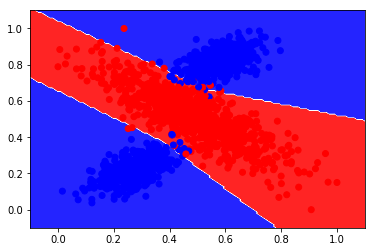

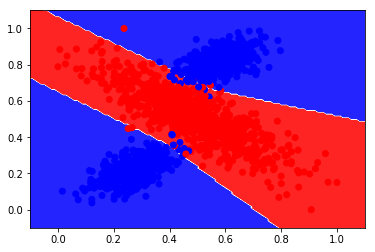


ACCURACY Normal:  0.99
CONFUSION MATRIX Normal: 
 [[198.   2.]
 [  2. 198.]]



ACCURACY Regularize:  0.9925
CONFUSION MATRIX Regularize: 
 [[198.   1.]
 [  2. 199.]]



ACCURACY AVERAGE Normal:  0.858
CONFUSION MATRIX AVERAGE Normal: 
 [[185.8  42.6]
 [ 14.2 157.4]]

ACCURACY AVERAGE Regularize:  0.9014999999999999
CONFUSION MATRIX AVERAGE Regularize: 
 [[192.2  31.6]
 [  7.8 168.4]]


In [119]:
#3. Split data into 5 groups
data_size = X.shape[0]
idx = np.array(range(data_size))
np.random.shuffle(idx)
idx_groups = np.split(idx, 5)
fold_groups = [(X[idxs], y[idxs]) for idxs in idx_groups]
five_sets = set(range(5))

acc_stat_norm = []
acc_stat_reg = []

con_mat_stat_norm = []
con_mat_stat_reg = []

for i in range(len(fold_groups)):
    print("Round: " + str(i+1))
    
    #4. Select test set and train data
    test_group_idx = i
    test_X, test_y = fold_groups[i]
    
    train_group_idx = list(five_sets - {i})
    train_X = [fold_groups[idx][0] for idx in train_group_idx]
    train_y = [fold_groups[idx][1] for idx in train_group_idx]
    
    train_X = np.concatenate(train_X)
    train_y = np.concatenate(train_y)
    
    #5. Initialize model
    NN_norm = NeuralNetwork(2, 7, 1, "ReLU", "sigmoid", None, True)
    NN_reg  = NeuralNetwork(2, 7, 1, "ReLU", "sigmoid", 0.0001, True)
    
    NN_reg.wih = NN_norm.wih.copy()
    NN_reg.who = NN_norm.who.copy()
    
    #6. Train the model
    NN_norm.fit(train_X, train_y, 100, 32, 1., 0, True)
    NN_reg.fit(train_X, train_y, 100, 32, 1., 0, True)
    loss, acc = NN_norm.calculateError(test_X, test_y)
    loss, acc = NN_reg.calculateError(test_X, test_y)
    
    #6. Plot decision boundary after trainning
    plot_decision_boundary(NN_norm, train_X, train_y)
    plot_decision_boundary(NN_reg, train_X, train_y)
    
    #7. compute accuracy and confusion matrix
    acc = 0
    y_pred = NN_norm.predict_classify(test_X)
    con_mat = np.zeros((2, 2))
    for i in range(len(y_pred)):
        con_mat[int(y_pred[i]), int(test_y[i][0])] += 1
        if test_y[i] == y_pred[i]:
            acc += 1
    con_mat_stat_norm.append(con_mat)
    acc = acc/len(y_pred)
    acc_stat_norm.append(acc)
    
    print('\nACCURACY Normal: ', acc)
    print('CONFUSION MATRIX Normal: \n', con_mat)
    print("\n")
    
    
    acc = 0
    y_pred = NN_reg.predict_classify(test_X)
    con_mat = np.zeros((2, 2))
    for i in range(len(y_pred)):
        con_mat[int(y_pred[i]), int(test_y[i][0])] += 1
        if test_y[i] == y_pred[i]:
            acc += 1
    con_mat_stat_reg.append(con_mat)
    acc = acc/len(y_pred)
    acc_stat_reg.append(acc)
    
    print('\nACCURACY Regularize: ', acc)
    print('CONFUSION MATRIX Regularize: \n', con_mat)
    print("\n")
    

print("\nACCURACY AVERAGE Normal: ", np.average(acc_stat_norm))
print("CONFUSION MATRIX AVERAGE Normal: \n", np.average(con_mat_stat_norm, axis=0))

print("\nACCURACY AVERAGE Regularize: ", np.average(acc_stat_reg))
print("CONFUSION MATRIX AVERAGE Regularize: \n", np.average(con_mat_stat_reg, axis=0))

## Hand-written digits recognition

In [120]:
# Load Data
X = np.genfromtxt('DATA/Digit_X_train.csv', delimiter=',').astype(np.float64)
y = np.genfromtxt('DATA/Digit_y_train.csv', delimiter=',').astype(np.float64)
y = y.reshape(y.shape[0], 1)

# Train NN
NN = NeuralNetwork(64, 80, 10, "ReLU", "softmax", 0.0001, True)
NN.fit(X, y, 200, 64, 0.5, 0, True)

Epoch:1/200	Loss:4.163452	Accuracy:0.464365	Learning rate:0.5	Elapse time[s]:0.266750
Epoch:2/200	Loss:0.835220	Accuracy:0.857461	Learning rate:0.5	Elapse time[s]:0.528464
Epoch:3/200	Loss:1.343679	Accuracy:0.804009	Learning rate:0.5	Elapse time[s]:0.792162
Epoch:4/200	Loss:0.776251	Accuracy:0.851893	Learning rate:0.5	Elapse time[s]:1.079329
Epoch:5/200	Loss:0.581544	Accuracy:0.909800	Learning rate:0.5	Elapse time[s]:1.343876
Epoch:6/200	Loss:0.570551	Accuracy:0.920935	Learning rate:0.5	Elapse time[s]:1.603534
Epoch:7/200	Loss:2.801195	Accuracy:0.633630	Learning rate:0.5	Elapse time[s]:1.873185
Epoch:8/200	Loss:0.554031	Accuracy:0.914254	Learning rate:0.5	Elapse time[s]:2.136190
Epoch:9/200	Loss:0.511159	Accuracy:0.935412	Learning rate:0.5	Elapse time[s]:2.410199
Epoch:10/200	Loss:0.459869	Accuracy:0.952116	Learning rate:0.5	Elapse time[s]:2.676462
Epoch:11/200	Loss:7.202509	Accuracy:0.412027	Learning rate:0.5	Elapse time[s]:2.943531
Epoch:12/200	Loss:0.471949	Accuracy:0.938753	Learnin

Epoch:95/200	Loss:0.244511	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:25.398489
Epoch:96/200	Loss:0.244176	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:25.667041
Epoch:97/200	Loss:0.243501	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:25.931411
Epoch:98/200	Loss:0.243680	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:26.192274
Epoch:99/200	Loss:0.242561	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:26.457077
Epoch:100/200	Loss:0.243548	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:26.725800
Epoch:101/200	Loss:0.241659	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:26.988987
Epoch:102/200	Loss:0.240149	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:27.281851
Epoch:103/200	Loss:0.240297	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:27.547733
Epoch:104/200	Loss:0.239233	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:27.825647
Epoch:105/200	Loss:0.238092	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:28.105816
Epoch:106/200	Loss:0.23794

Epoch:188/200	Loss:0.196890	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:50.839826
Epoch:189/200	Loss:0.195038	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:51.101106
Epoch:190/200	Loss:0.194310	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:51.364371
Epoch:191/200	Loss:0.193681	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:51.626174
Epoch:192/200	Loss:0.193012	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:51.893422
Epoch:193/200	Loss:0.192955	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:52.156575
Epoch:194/200	Loss:0.192585	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:52.420933
Epoch:195/200	Loss:0.191986	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:52.681387
Epoch:196/200	Loss:0.191200	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:52.945830
Epoch:197/200	Loss:0.191104	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:53.213336
Epoch:198/200	Loss:0.190665	Accuracy:1.000000	Learning rate:0.5	Elapse time[s]:53.477836
Epoch:199/200	Loss:0.

In [121]:
# Test NN
X = np.genfromtxt('DATA/Digit_X_test.csv', delimiter=',').astype(np.float64)
y = np.genfromtxt('DATA/Digit_y_test.csv', delimiter=',').astype(np.float64)
y = y.reshape(y.shape[0], 1)

_, accur = NN.calculateError(X, y)
print("Accuracy: {}".format(accur))

Accuracy: 0.932146829810901
